In [1]:
import sqlutilpy as sqlutil
from astropy.table import Table
from os import path
import pickle
import numpy as np
import importlib
import astropy.coordinates as coord
import astropy.units as u
import healpy as hp

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
from gala.coordinates.reflex import reflex_correct
from astropy_healpix import HEALPix
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xdgmm import XDGMM
import pandas as pd
import matplotlib as mpl

In [4]:
def queryDatabase(query, columns, post_query, cache_file='db.pickle'):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

In [5]:
def calc_distance(g, ebv):
    Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [6]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [7]:
from matplotlib.patches import Ellipse
def error_ellipse(mu, cov, ax=None, factor=1.0, alpha=1.0, **kwargs):
    """
    Plot the error ellipse at a point given its covariance matrix.

    """
    # some sane defaults
    facecolor = kwargs.pop('facecolor', 'none')
    edgecolor = kwargs.pop('edgecolor', 'k')
    x, y = mu
    U, S, V = np.linalg.svd(cov)
    theta = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    ellipsePlot = Ellipse(xy=[x, y],
                          width=2 * np.sqrt(S[0]) * factor,
                          height=2 * np.sqrt(S[1]) * factor,
                          angle=theta,
                          facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, **kwargs)
    if ax is None:
        ax = pl.gca()
    ax.add_artist(ellipsePlot)

    return ellipsePlot

##  Query WSDB

In [12]:
columns = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', \
           'parallax_error', 'int_average_g', \
           'int_average_g_error', 'g_absorption', 'g_absorption_error', \
           'pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'ebv', 'peak_to_peak_g', \
           'num_clean_epochs_g', 'astrometric_excess_noise', 'phot_bp_mean_mag', 'phot_rp_mean_mag', \
           'g_transit_time', 'g_transit_flux', 'pf', 'best_classification', 'gs.source_id']
query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr, gaia_DR2.epoch_photometry as ep {1}"""
cuts = "WHERE gs.source_id=rr.source_id AND gs.source_id=ep.source_id"

In [13]:
res = queryDatabase(query, columns, cuts, cache_file='gaiaRRlyrae.pkl')
d = Table(res)

In [10]:
d

<Table length=141387>
       ra               dec        ...         pf        best_classification
    float64           float64      ...      float64             str10       
---------------- ----------------- ... ----------------- -------------------
44.3229067716618 0.785227790628009 ... 0.554450437448686                RRab
 46.341468915923  1.54199810825252 ... 0.555453836760359                RRab
44.9246838297814  3.64213065890743 ...               nan                 RRc
48.9985102595523  5.23050155551168 ...               nan                 RRc
47.3821385903558  5.73801743216368 ... 0.466382585628468                RRab
46.7021000794783  6.07592242824584 ... 0.517983383519085                RRab
48.3678732077726  6.60387550184972 ...  0.48781452681807                RRab
47.8628622178955  6.79135580304128 ... 0.521151857196641                RRab
43.0195262983927  3.33972166929035 ...               nan                 RRc
41.9722515950264  4.31941215865343 ... 0.504111479289292                RRab
             ...               ... ...               ...                 ...
312.662132667574 -2.61596945692143 ... 0.584954516170397                RRab
312.905304537471 -2.64231888828496 ...               nan                 RRc
312.288781299977 -2.46476061439429 ... 0.496691417768404                RRab
312.510120111327 -2.38415224268153 ...               nan                 RRc
312.529376144582 -2.35832853462566 ...               nan                 RRc
314.074907093703 -1.65385452302483 ...               nan                 RRc
313.579907893526 -1.55597182325554 ...               nan                 RRc
 313.88332686067 -1.52931259541927 ...  0.59007042019392                RRab
314.918841517052 -1.54606685515461 ...               nan                 RRc
314.440359679555 -1.43513469514313 ... 0.570041953084196                 RRd

In [11]:
d.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g',
 'astrometric_excess_noise',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'g_transit_time',
 'g_transit_flux',
 'pf',
 'best_classification']

In [12]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

3.1443763446807864
0.5065959620475795
0.3024415850639551
0.18543516159057688
0.07993161678314263
0.026179099082946702
0.009283938407898554
0.003983092308044375
0.0019087672233581293
0.0010056304931640309


/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [13]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


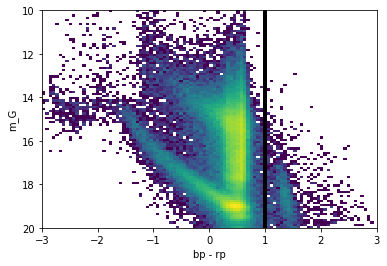

In [14]:
plt.hist2d(bprp, d['int_average_g'] - Ag, range=[[-3, 3],[10, 20]], bins=100, norm=mpl.colors.LogNorm())
plt.axvline(1, linewidth=4, color='black')
#plt.axvline(0, linewidth=4, color='black')
#plt.axhline(18.5, linewidth=4, color='black')
plt.xlabel('bp - rp')
plt.ylabel('m_G')
#xx = np.linspace(-3, 0, 100)
#plt.plot(xx, 2.3*xx + 17, linewidth=4, color='black')
plt.gca().invert_yaxis()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


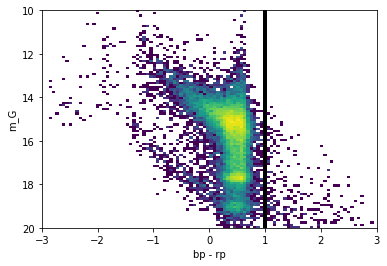

In [15]:
select = d['num_clean_epochs_g'] < 20
plt.hist2d(bprp[select], d['int_average_g'][select] - Ag[select], range=[[-3, 3],[10, 20]], bins=100, norm=mpl.colors.LogNorm())
plt.axvline(1, linewidth=4, color='black')
#plt.axvline(0, linewidth=4, color='black')
#plt.axhline(18.5, linewidth=4, color='black')
plt.xlabel('bp - rp')
plt.ylabel('m_G')
#xx = np.linspace(-3, 0, 100)
#plt.plot(xx, 2.3*xx + 17, linewidth=4, color='black')
plt.gca().invert_yaxis()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


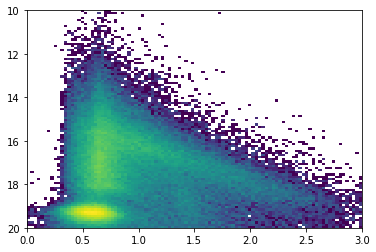

In [16]:
plt.hist2d(d['phot_bp_mean_mag'] - d['phot_rp_mean_mag'], d['int_average_g'], range=[[0, 3],[10, 20]], bins=100, norm=mpl.colors.LogNorm())
plt.gca().invert_yaxis()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


(array([[0., 0., 0., ..., 2., 1., 5.],
        [0., 0., 2., ..., 2., 4., 0.],
        [0., 1., 0., ..., 1., 3., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 2.],
        [0., 1., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
        1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42,
        1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64,
        1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86,
        1.88, 1.9 , 1.92, 1.94, 1.96, 1.98, 2.  ]),
 array([16.  , 16.08, 16.16, 16.24, 16.32, 16.4 , 16.48, 16.56, 16.64,
        16.72, 16.8 , 16.88, 16.96, 17.04, 17.12, 17.2 , 17.28, 17.36,
        17.44, 17.52, 17.6 , 17.68, 17.76, 17.84, 17.92, 18.  , 18.08,
        18.16, 18.24, 18.32, 18.4 , 18.48, 18.56, 18.64, 18.72, 18.8 ,
        18.88, 18.96, 19.04, 19.12, 19.2 , 19.28, 19.36, 19.44, 19.52,
        19.6 , 19.68, 19.76, 19.84, 19.92, 20.  

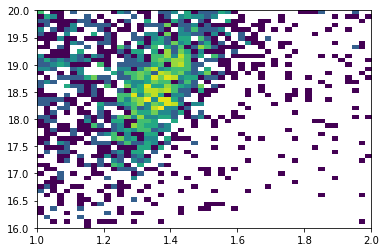

In [17]:
plt.hist2d(bprp, d['int_average_g'] - Ag, range=[[1, 2],[16, 20]], bins=50, norm=mpl.colors.LogNorm())


In [18]:
c = coord.SkyCoord(ra=d['ra']*u.deg, 
                   dec=d['dec']*u.deg, 
                   pm_ra_cosdec=d['pmra']*u.mas/u.yr,
                   pm_dec=d['pmdec']*u.mas/u.yr)

cGal = c.transform_to(coord.Galactic)

In [ ]:
import scipy.interpolate

In [78]:
np.sum(d['num_clean_epochs_g'] > 240)

5

In [87]:
selection = d['num_clean_epochs_g'] > 240
for i in range(np.sum(selection)):
    print(d['pf'][selection][i])
    flux = d['g_transit_flux'][selection][i]
    plt.scatter(d['g_transit_time'][selection][i]%d['pf'][selection][i],
             d['g_transit_flux'][selection][i]/np.max(flux[~np.isnan(flux)]), 
             label=d['best_classification'][selection][i])
plt.legend()



0.605013107615129


TypeError: only integer scalar arrays can be converted to a scalar index

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


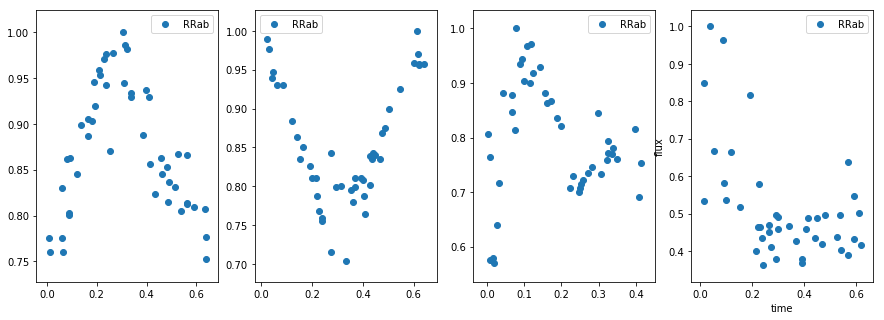

In [58]:

m_g = d['int_average_g'] - Ag
selection = (bprp <1.6) & (bprp>1.2) & (m_g < 20 ) & (m_g> 17) & (d['num_clean_epochs_g'] > 40)
#print(np.sum(selection))
#print(d['best_classification'][selection], d['pf'][selection])
nplots = np.sum(~np.isnan(d['pf'][selection]))
fig, ax = plt.subplots(1, nplots, figsize=(15, 5))
j = 0
for i in range(np.sum(selection)):
    if ~np.isnan(d['pf'][selection][i]):
        #xx = d['g_transit_time'][selection][i]%d['pf'][selection][i]
        #yy = d['g_transit_flux'][selection][i]/np.max(d['g_transit_flux'][selection][i])
        #f = scipy.interpolate.Akima1DInterpolator(xx, yy)                                             
        ax[j].scatter(d['g_transit_time'][selection][i]%d['pf'][selection][i],
             d['g_transit_flux'][selection][i]/np.max(d['g_transit_flux'][selection][i]), 
             label=d['best_classification'][selection][i])
        ax[j].legend()
        j+=1
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


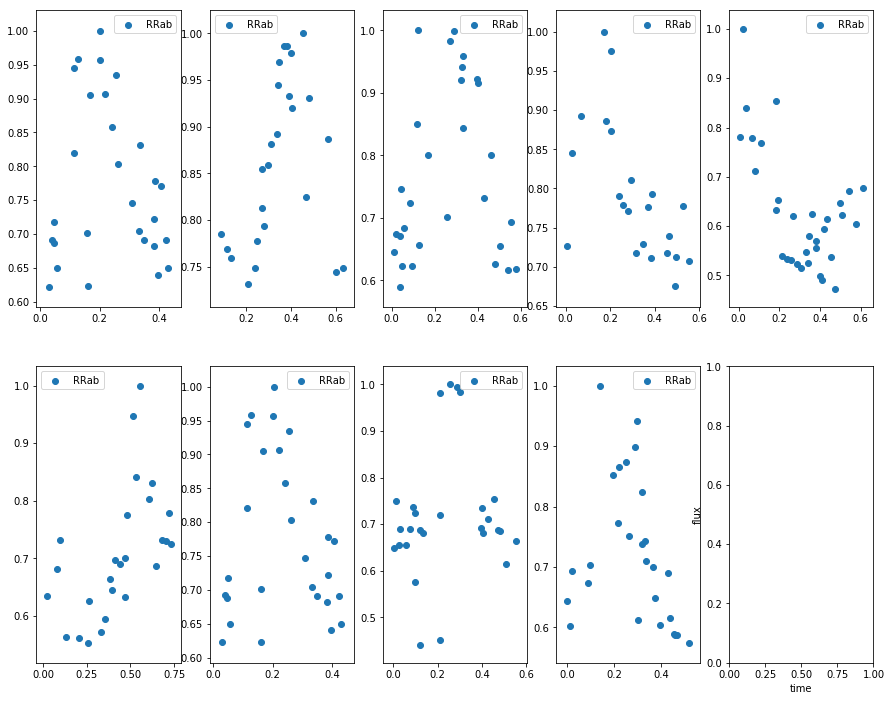

In [62]:
m_g = d['int_average_g'] - Ag
selection = (bprp <1.6) & (bprp>1.2) & (m_g < 20 ) & (m_g> 17) & (d['num_clean_epochs_g'] > 20)
#print(np.sum(selection))
#print(d['best_classification'][selection], d['pf'][selection])
rand = np.random.randint(0, np.sum(selection), 15)
nplots = np.sum(~np.isnan(d['pf'][selection][rand]))
if nplots < 5:
    fig, ax = plt.subplots(1, nplots, figsize=(15, 5))
else: 
    fig, ax = plt.subplots(2, int(nplots/2)+1, figsize=(15, 12))
    ax = ax.flatten()
j=0
for i in rand:
    if ~np.isnan(d['pf'][selection][i]):
        #xx = d['g_transit_time'][selection][i]%d['pf'][selection][i]
        #yy = d['g_transit_flux'][selection][i]/np.max(d['g_transit_flux'][selection][i])
        #f = scipy.interpolate.Akima1DInterpolator(xx, yy)                                             
        ax[j].scatter(d['g_transit_time'][selection][i]%d['pf'][selection][i],
             d['g_transit_flux'][selection][i]/np.max(d['g_transit_flux'][selection][i]), 
             label=d['best_classification'][selection][i])
        ax[j].legend()
        j+=1
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()

1458


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


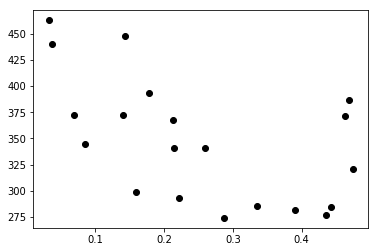

In [23]:
m_g = d['int_average_g'] - Ag
selection = (bprp <1.6) & (bprp>1.2) & (m_g < 20 ) & (m_g> 17)
print(np.sum(selection))
plt.plot(d['g_transit_time'][selection][i]%d['pf'][selection][i], d['g_transit_flux'][selection][i], 'ko')

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


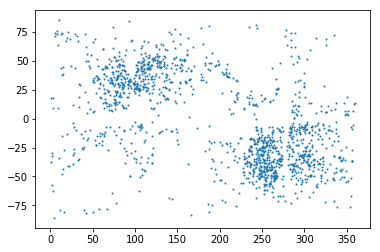

In [149]:
m_g = d['int_average_g'] - Ag
selection = (bprp <1.6) & (bprp>1.2) & (m_g < 20 ) & (m_g> 17)
plt.scatter(cGal[selection].l, cGal[selection].b, s=1)

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Text(0.5,1,'dust binaries')

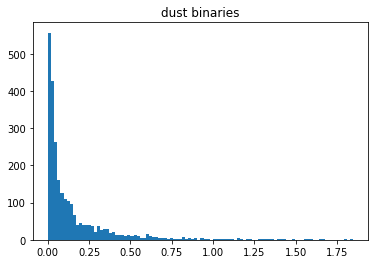

In [128]:
plt.hist(d['ebv'][bprp > 1], bins=100)
plt.title('dust binaries')

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


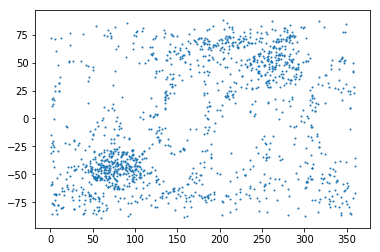

In [132]:
m_g = d['int_average_g'] - Ag
selection = (bprp <1.6) & (bprp>1.2) & (m_g < 20 ) & (m_g> 17)
plt.scatter(d['ra'][selection], d['dec'][selection], s=1)

In [122]:
calc_distance(18.5, 0)

39.810717055349734

Text(0.5,0,'E(B-V)')

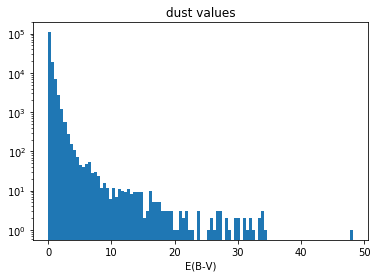

In [83]:
plt.hist(d['ebv'], bins=100, log=True)
plt.title('dust values')
plt.xlabel('E(B-V)')

In [108]:
bp_rp = d['phot_bp_mean_mag'] - Abp - (d['phot_rp_mean_mag'] - Arp)
M_G = d['int_average_g'] - Ag  
(M_G < 2.3*bp_rp + 17) & (bp_rp < 0 )
g1 = ~np.isnan(d['pmra']) & ~np.isnan(d['pmdec'] ) & \
       (d['ebv'] <= 5) & \
       (M_G < 18.5) & \
       (bp_rp < 1) & \
       (bp_rp > 0)
good = np.logical_or(g1, ((M_G < 2.3*bp_rp + 17) & (bp_rp < 0 ) & ~np.isnan(d['pmra']) & ~np.isnan(d['pmdec'] )))
np.sum(good), np.sum(~good)

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


(89960, 50824)

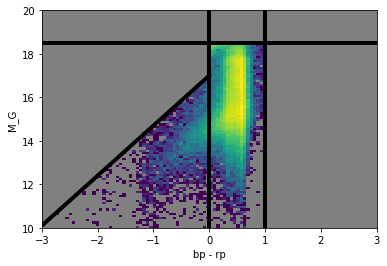

In [109]:
plt.hist2d(bprp[good], d['int_average_g'][good] - Ag[good], range=[[-3, 3],[10, 20]], bins=100, norm=mpl.colors.LogNorm())
plt.axvline(1, linewidth=4, color='black')
plt.axvline(0, linewidth=4, color='black')
plt.axhline(18.5, linewidth=4, color='black')
plt.xlabel('bp - rp')
plt.ylabel('M_G')
xx = np.linspace(-3, 0, 100)
plt.plot(xx, 2.3*xx + 17, linewidth=4, color='black')
#plt.gca().invert_yaxis()

In [110]:
data = d[good]
print(len(data))

89960


Text(0.5,1,'dust values')

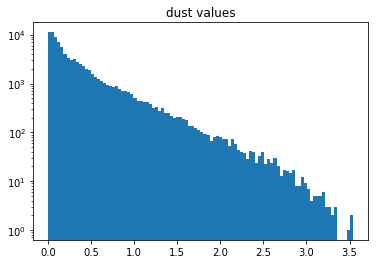

In [111]:
plt.hist(data['ebv'], bins=100, log=True)
plt.title('dust values')

In [112]:
distances = calc_distance(data['int_average_g'], data['ebv'])
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

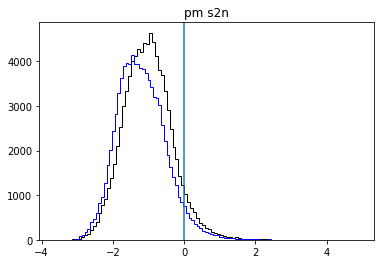

In [113]:
plt.hist(np.log10(np.abs(data['pmra_error']/data['pmra'])), bins=100, histtype='step', color='black')
plt.hist(np.log10(np.abs(data['pmdec_error']/data['pmdec'])), bins=100, histtype='step', color='blue')
plt.title('pm s2n')
plt.axvline(np.log10(1))

Text(0,0.5,'pm dec error')

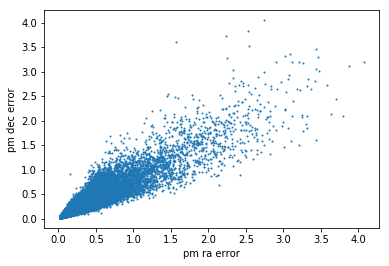

In [114]:
plt.scatter(data['pmra_error'], data['pmdec_error'], s=1)
plt.xlabel('pm ra error')
plt.ylabel('pm dec error')

Text(0.5,1,'distances')

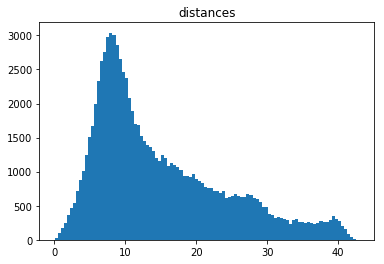

In [115]:
plt.hist(distances, bins=100)
plt.title('distances')

In [116]:
vl = (cGal.pm_l_cosb*cGal.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGal.pm_b*cGal.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vra = (cCorrect.pm_ra_cosdec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vdec = (cCorrect.pm_dec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vra_no = (c.pm_ra_cosdec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vdec_no = (c.pm_dec*cCorrect.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())

In [117]:
v_tan = np.sqrt(vl.value**2. + vb.value**2.)

(100, 27574.14733785195)

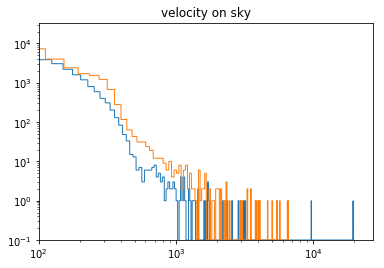

In [118]:
plt.hist(vl.value, bins=1000, log=True, histtype='step')
plt.hist(vb.value, bins=1000, log=True, histtype='step')
plt.title('velocity on sky')
plt.xscale('log')
plt.xlim(100,)

In [36]:
X = pd.DataFrame(data={'l':cGal.l.value, 
                       'b':cGal.b.value,
                       'vl':vl,
                       'vb':vb,
                       'distance':distances})


In [37]:
v_err = np.sqrt(data['pmra_error']**2 + data['pmdec_error']**2)

In [38]:
dminus = calc_distance(data['int_average_g'] + data['int_average_g_error'], data['ebv'])
dplus = calc_distance(data['int_average_g'] - data['int_average_g_error'], data['ebv'])

In [39]:
d_err = 0.5*((dminus - distances) + (distances - dplus))

Text(0,0.5,'distance uncertainty [kpc]')

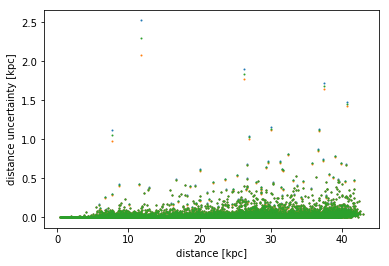

In [40]:
plt.scatter(distances, dminus - distances, s=1)
plt.scatter(distances, distances - dplus, s=1)
plt.scatter(distances, d_err, s=1)
plt.xlabel('distance [kpc]')
plt.ylabel('distance uncertainty [kpc]')
#plt.scatter(distances, dplus, s=1)

In [41]:
Xerr = pd.DataFrame(data={'l_err':np.zeros(len(cGal)),
                          'b_err':np.zeros(len(cGal)),
                          'vl_err':v_err, 
                          'vb_err':v_err,
                          'd_err':d_err})

In [42]:
XDGMM?

Init signature: XDGMM(n_components=1, n_iter=0, tol=1e-05, method='astroML', labels=None, random_state=None, V=None, mu=None, weights=None, filename=None, w=0.0)
Docstring:     
Extreme Deconvolution

Class that can fit an extreme deconvolution (XD) model to the data

Parameters
----------
n_components: integer
    Number of gaussian components to fit to the data (default=1)
n_iter: integer (optional)
    Number of EM iterations to perform
    (default=100 for astroML, 1e9 for Bovy).
tol: float (optional)
    Stopping criterion for EM iterations (default=1E-5).
method: string (optional)
    astroML or Bovy (default="astroML").
labels: array_like (optional), shape = (n_features,)
    Array of labels for parameters used in the fit. Order matters
    (e.g., the first label corresponds to the first parameter in the
    alpha array, etc.) (default = None).

Can be initialized with already known mu, alpha, and V:

alpha: array_like (optional), shape = (n_components,)
    Weights for each gau

In [54]:
n_components = 32
try: 
    xdgmm = XDGMM(filename = 'xdgmm_n{0}.fit'.format(n_components))
except FileNotFoundError:
    xdgmm = XDGMM(n_components=n_components, method='Bovy', n_iter=int(1e9), w=0.00001)
    xdgmm.fit(np.array(X[['l', 'b', 'vl', 'vb', 'distance']]), np.array(Xerr[['l_err', 'b_err', 'vl_err', 'vb_err', 'd_err']]))
    xdgmm.save_model(filename='xdgmm_n{0}.fit'.format(xdgmm.n_components))

/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [55]:
samples = xdgmm.sample(len(data))

In [56]:
samples[:,0]

array([6.68407155, 5.82981705, 7.28086031, ..., 3.69379001, 4.69350259,
       2.38643267])

In [57]:
import matplotlib as mpl

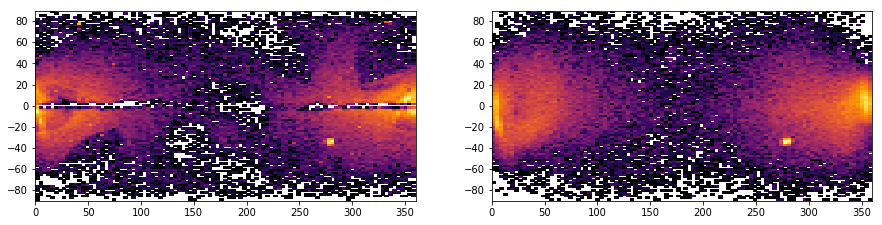

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)
xx = [X['l'], samples[:, 0]]
yy = [X['b'], samples[:, 1]]
for i, (x, y) in enumerate(zip(xx, yy)):
    H, xe, ye = np.histogram2d(x, y, bins=(xbins, ybins))
    im = ax[i].pcolormesh(xe, ye, H.T,
          cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)
    

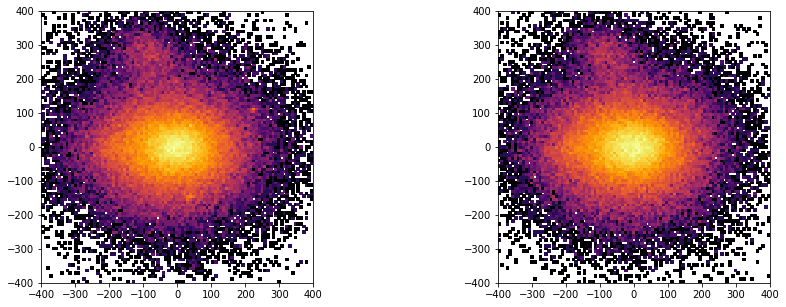

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(-400, 400, nbins)
ybins = np.linspace(-400, 400, nbins)
xx = [X['vl'], samples[:, 2]]
yy = [X['vb'], samples[:, 3]]
for i, (x, y) in enumerate(zip(xx, yy)):
    H, xe, ye = np.histogram2d(x, y, bins=(xbins, ybins))
    im = ax[i].pcolormesh(xe, ye, H.T,
          cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)


Text(0,0.5,'b')

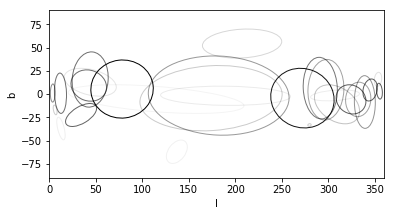

In [60]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for g in range(xdgmm.n_components):
    mu = xdgmm.mu[g][:2]
    amp = xdgmm.weights[g]
    V = xdgmm.V[g]
    inv_V = np.linalg.inv(V)
    inv_cov = inv_V[:2, :2]
    cov = np.linalg.inv(inv_cov)
    #print(mu, cov)
    blah = error_ellipse(mu, cov, ax=ax, alpha=amp/np.max(xdgmm.weights))
    #print(cov.shape)
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel('l')
ax.set_ylabel('b')

Text(0,0.5,'v l')

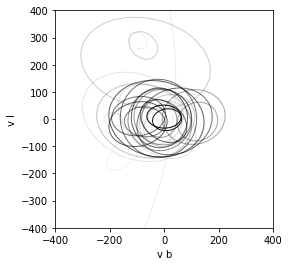

In [61]:
lim = 400
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for g in range(xdgmm.n_components):
    mu = xdgmm.mu[g][2:4]
    amp = xdgmm.weights[g]
    V = xdgmm.V[g]
    inv_V = np.linalg.inv(V)
    inv_cov = inv_V[2:4, 2:4]
    cov = np.linalg.inv(inv_cov)
    #print(mu, cov)
    blah = error_ellipse(mu, cov, ax=ax, alpha=amp/np.max(xdgmm.weights))
    #print(cov.shape)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel('v b')
ax.set_ylabel('v l')


Text(0,0.5,'distance')

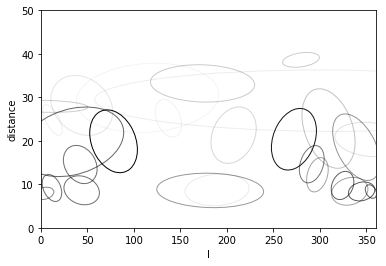

In [62]:
lim = 400
fig, ax = plt.subplots() # subplot_kw={'aspect': 'equal'})
for g in range(xdgmm.n_components):
    mu = xdgmm.mu[g][[0,4]]
    amp = xdgmm.weights[g]
    V = xdgmm.V[g]
    inv_V = np.linalg.inv(V)
    inv_cov = inv_V[[[0,0],[0,4]],[[4,0], [4,4]]]
    cov = np.linalg.inv(inv_cov)
    #print(mu, cov)
    blah = error_ellipse(mu, cov, ax=ax, alpha=amp/np.max(xdgmm.weights))
    #print(cov.shape)
ax.set_xlim(0, 360)
ax.set_ylim(0, 50)
ax.set_xlabel('l')
ax.set_ylabel('distance')


Text(0,0.5,'proper motion')

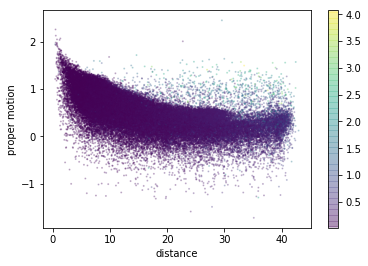

In [63]:
plt.scatter(distances, np.log10(np.sqrt(data['pmra']**2 + data['pmdec']**2)), s=1, alpha=0.25, c=data['pmra_error'])
plt.colorbar()
plt.xlabel('distance')
plt.ylabel('proper motion')

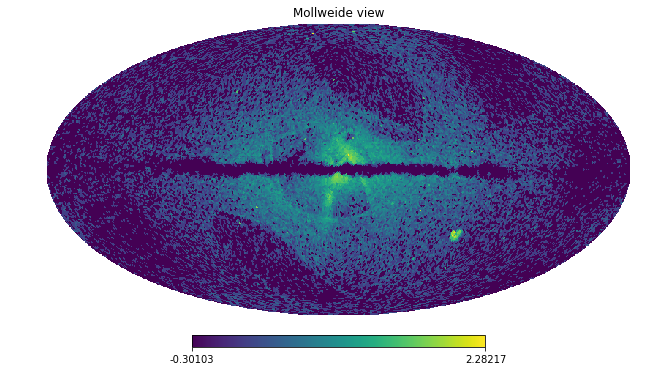

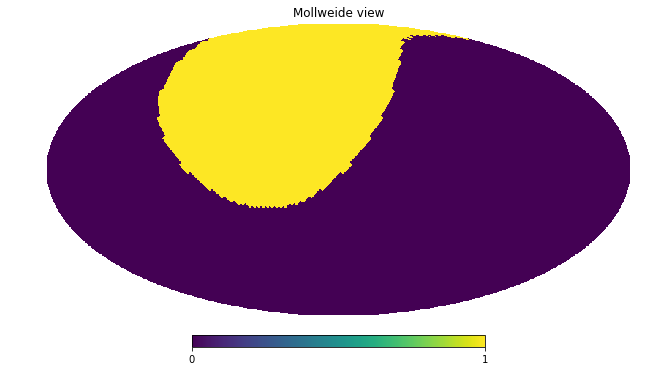

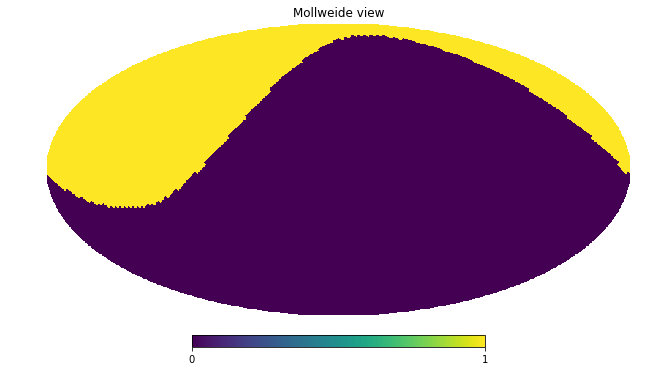

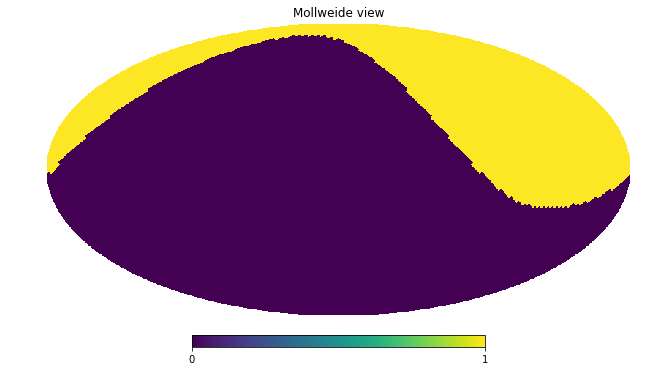

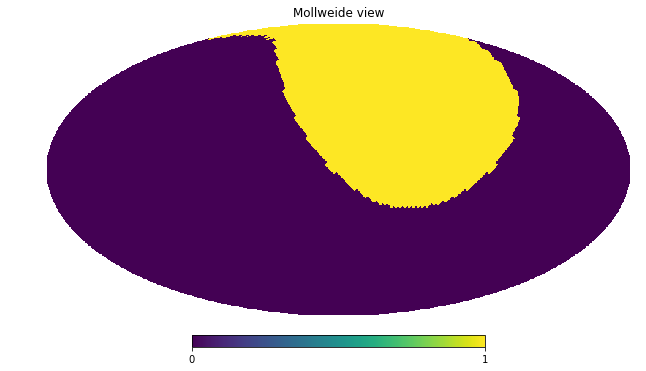

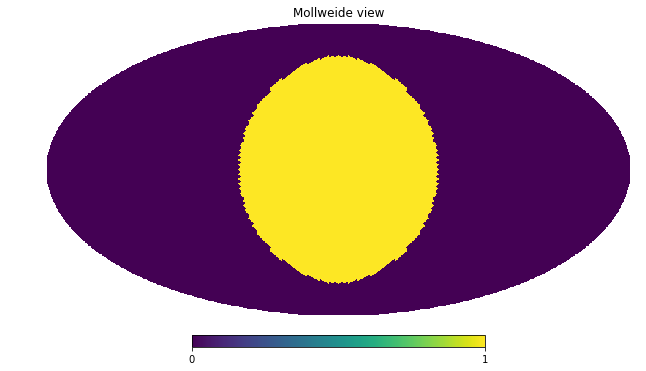

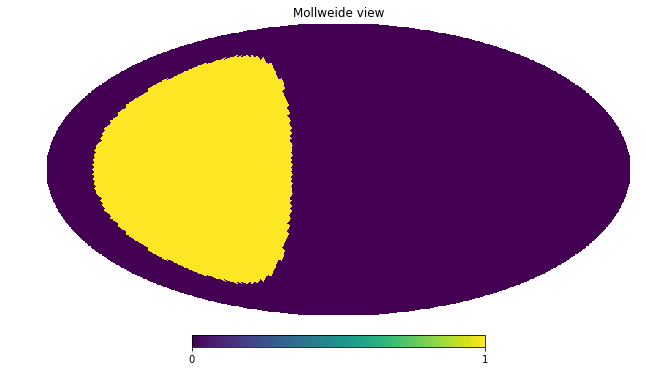

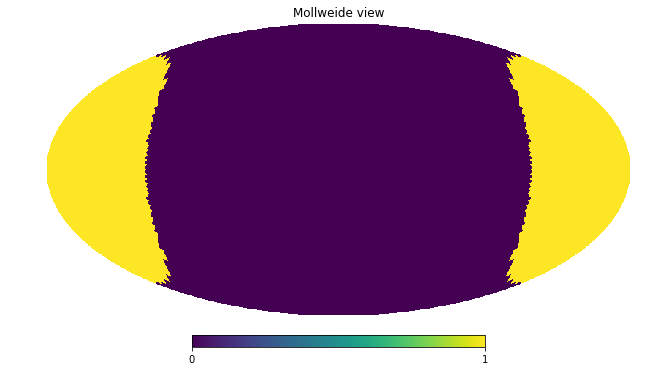

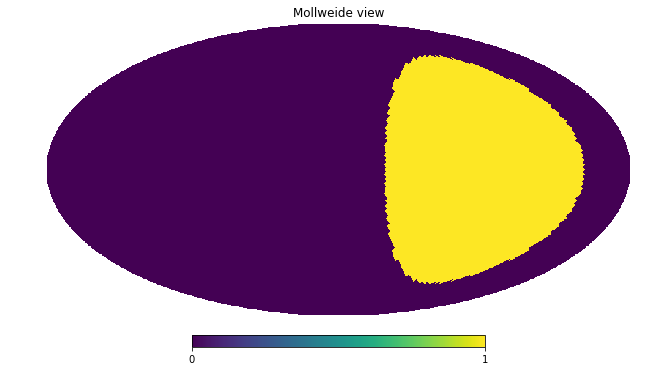

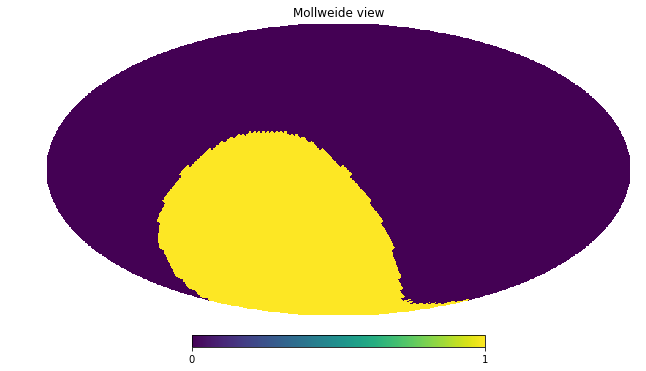

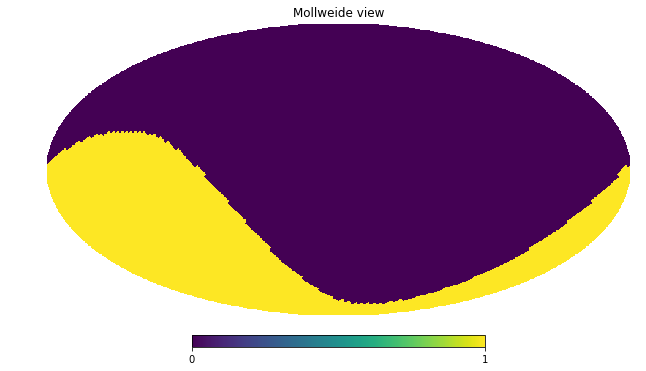

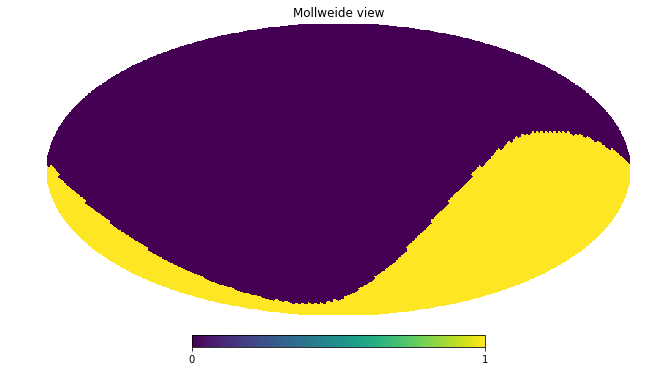

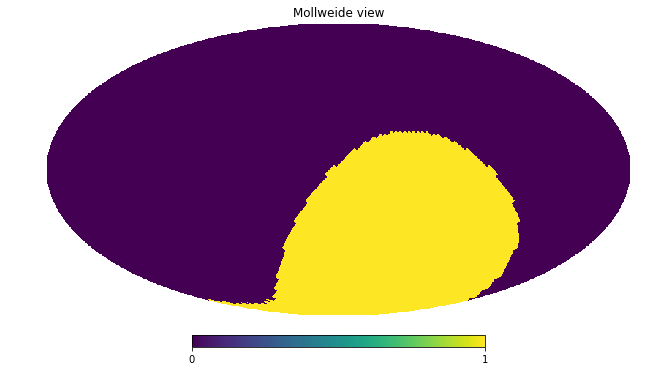

In [64]:
nside = 64
hpixMap = HEALPix(order="ring", nside=nside, frame=coord.Galactic())
pixnums_m = hpixMap.skycoord_to_healpix(cGal)
omap = np.bincount(pixnums_m, minlength=hpixMap.npix)
mapSky = hp.mollview(np.log10(omap+0.5), return_projected_map=True)


#pixelize sky

hpixSearch = HEALPix(nside=1, frame=coord.Galactic(), order='ring')
hpix = HEALPix(nside=32, frame=coord.Galactic(), order='ring')
pixel_index = hpix.skycoord_to_healpix(cGal)
lim = 200
nbins = 128
#dmins = np.array([0, 5, 10, 15, 20])*u.kpc
#dmaxs = np.array([10, 15, 20, 25, 1000])*u.kpc
dmins = [0*u.kpc]
dmaxs = [1000*u.kpc]
vmax = 10
#grab all pixels with some radius around each pixel
for pixnumber in range(hpixSearch.npix):
    pixcoord = hpixSearch.healpix_to_skycoord(pixnumber)
    pixels = hpix.cone_search_skycoord(pixcoord, radius=60 * u.deg)        
    indices_pix = np.array([np.array(pixel_index == p).astype(np.bool_) for p in pixels]).any(axis=0)
    for dmin, dmax in zip(dmins, dmaxs):
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        indices = indices_pix & (cGal.distance >= dmin) & (cGal.distance < dmax)
        xbins = np.linspace(-lim, lim, nbins)
        ybins = xbins
        H, xe, ye = np.histogram2d(vl[indices], vb[indices], bins=(xbins, ybins))
        smooth = gaussian_filter(H, sigma=0.75)
        im = ax[0].pcolormesh(xe, ye, smooth.T,
                  cmap='inferno', vmin=1, vmax=vmax)#, vmax=20) #, vmin=-100, vmax=100)
        fig.colorbar(im, ax=ax[0])
        mask = np.zeros(hpix.npix)
        mask[pixels] = 1.0
        piximg = hp.mollview(mask, return_projected_map=True) #,rot=(0, 90, 0))
        im2 = ax[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90], cmap='inferno', vmax=1)
        im3 = ax[1].imshow(piximg, origin='lower', extent=[-180, 180, -90, 90], cmap='gist_gray', vmax=0.5, alpha=0.5)
        ax[0].set_xlabel('$v_l$ [km/s]')
        ax[0].set_ylabel('$v_b$ [km/s]')
        ax[1].set_xlabel('l')
        ax[1].set_ylabel('b')

        #im = ax.scatter(vl[indices], vb[indices], s=1)
        #ax.set_xlim(-lim, lim)
        #ax.set_ylim(-lim, lim)
        #im.set_rasterized(True)
        im2.set_rasterized(True)
        im3.set_rasterized(True)
        fig.savefig('vlvb_{0:03d}_{1:02d}.png'.format(pixnumber, np.int(dmin.value)))
        plt.close(fig)
        #plt.xlim(0, 360)
        #plt.ylim(-90, 90)

Text(0.5,1,'RR lyrae velocities')

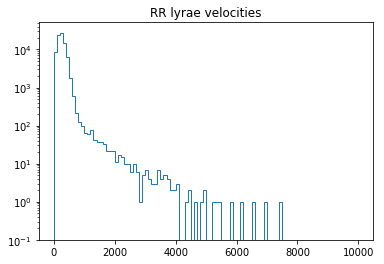

In [65]:
plt.hist(np.sqrt(vra_no.value**2. + vdec_no.value**2.), bins=100, histtype='step', range=[0, 1e4], log=True)
plt.title('RR lyrae velocities')

Text(0.5,1,'RR lyrae Velocity on Sky')

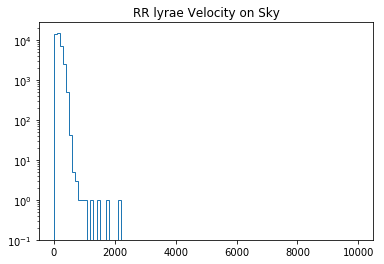

In [66]:
sig = 5
interesting = (np.abs(data['pmra']/data['pmra_error']) > sig) & \
              (np.abs(data['pmdec']/data['pmdec_error']) > sig) & \
              (v_tan > 2000) & \
              (data['int_average_g'] < 17)

select = (np.abs(data['pmra']/data['pmra_error']) > sig) & (np.abs(data['pmdec']/data['pmdec_error']) > sig) & (data['int_average_g'] < 17)
plt.hist(np.sqrt(vl[select].value**2. + vb[select].value**2), bins=100, histtype='step', range=[0, 10000], log=True)
plt.title('RR lyrae Velocity on Sky')

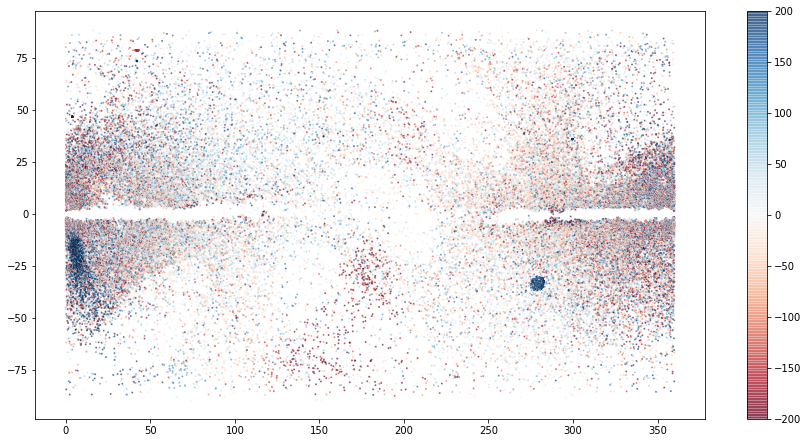

In [69]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.l, cGal.b, s=1, alpha=0.5, c=vb.value, vmax=200, vmin=-200, cmap='RdBu')
plt.colorbar()

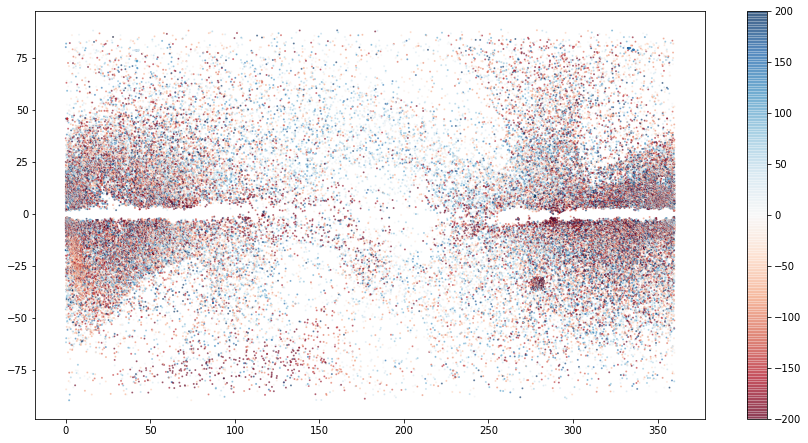

In [70]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.l, cGal.b, s=1, alpha=0.5, c=vl.value, vmax=200, vmin=-200, cmap='RdBu')
plt.colorbar()

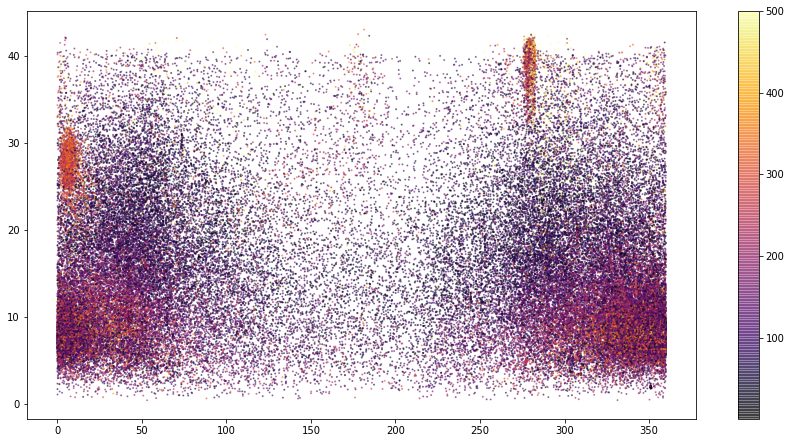

In [73]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.l, cGal.distance, s=1, alpha=0.5, c=v_tan, cmap='inferno', vmax=500)
plt.colorbar()

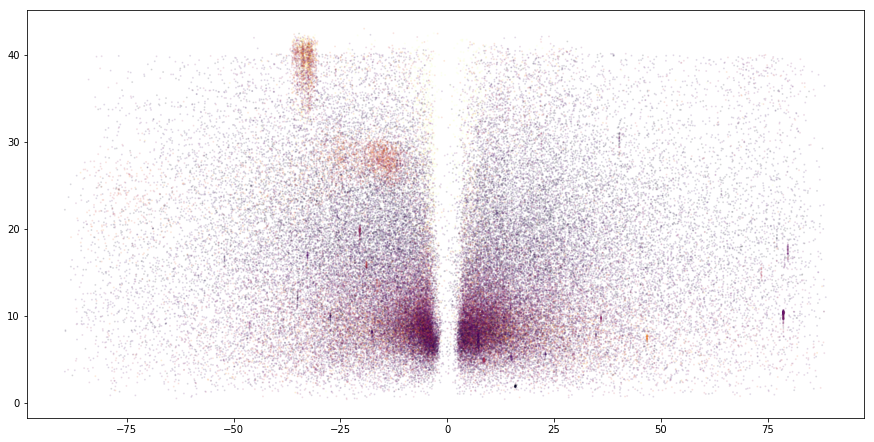

In [75]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.b, cGal.distance, s=1, alpha=0.1, c=v_tan, cmap='inferno', vmax=500)
#plt.colorbar()

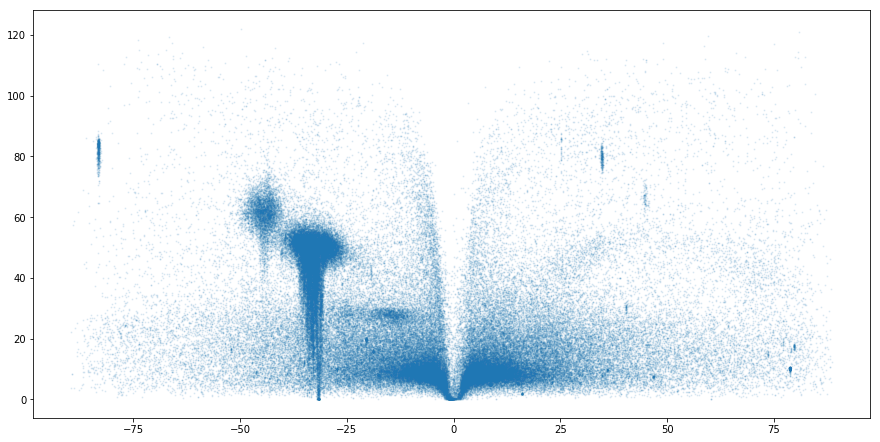

In [124]:
plt.figure(figsize=(15, 7.5))
plt.scatter(cGal.b, cGal.distance, s=1, alpha=0.1)

In [120]:
lmc = (np.abs(cGal.l - 280*u.deg).value < 10) & (np.abs(cGal.b + 35*u.deg).value < 10)

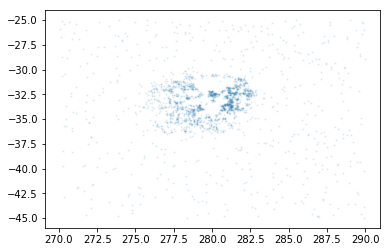

In [121]:
plt.scatter(cGal[lmc].l, cGal[lmc].b, s=1, alpha=0.1)

(-10, 10)

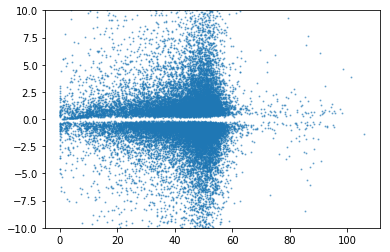

In [115]:
plt.scatter(distances[lmc], data['parallax_error'][lmc]/data['parallax'][lmc], s=1, alpha=0.5)
plt.ylim(-10, 10)

(0, 100)

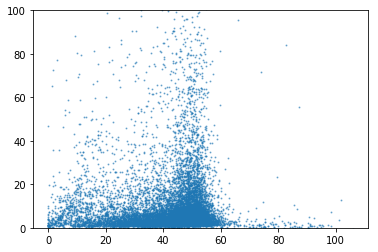

In [104]:
plt.scatter(distances[lmc], 1./data['parallax'][lmc], s=1, alpha=0.5)
plt.ylim(0, 100)

In [106]:
data[interesting]

<Table length=5>
       ra               dec        ...   peak_to_peak_g  num_clean_epochs_g
    float64           float64      ...      float64            int32       
---------------- ----------------- ... ----------------- ------------------
38.2337922286941  4.40488323607676 ... 0.622223264703742                 16
181.926442489243 -26.6156183627833 ...  0.24291700463106                 28
265.191096709516  6.06403324240826 ... 0.267562650096053                 27
105.871422861466  -84.413077083078 ... 0.524813600210454                 18
247.356004921696 -57.3857021648357 ...  0.82941648640754                 27

In [108]:
v_tan[interesting]

array([2560.40365454, 3306.16762548, 2101.56130253, 2165.62346875,
       7345.90344388])

In [126]:
distances[interesting]

<Column name='int_average_g' dtype='float64' length=5>
17.137673585853186
16.143018511874207
  9.81756577613148
15.014405795448976
 8.037386534743224

In [127]:
data['ebv'][interesting]

<Column name='ebv' dtype='float32' length=5>
0.052554
0.080629
0.155894
0.220485
0.362222

In [82]:
cGal[interesting]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(164.65682368, -50.06133244, 17.13767359),
     (290.95013045,  35.2365857 , 16.14301851),
     ( 30.29715556,  18.46809136,  9.81756578),
     (296.68452171, -26.69653802, 15.0144058 ),
     (329.11472184,  -6.05621696,  8.03738653)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-20.02943289, -24.33307483,   27.00603225),
     (-38.89993789,  18.79720928, -169.71008581),
     (-30.05027144, -33.70546021,  122.50656485),
     (-23.17412311,  19.71643239, -184.21386504),
     ( 77.22591391, 176.65877021, -109.86448283)]>

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


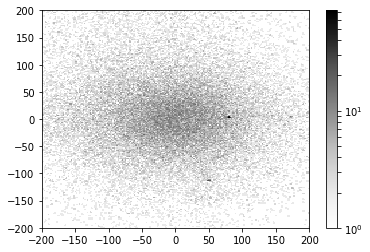

In [126]:
max = 200
xbins = np.linspace(-max, max, 200)
ybins = xbins
H, xe, ye = np.histogram2d(vl, vb, bins=(xbins, ybins))


im = plt.pcolormesh(xe, ye, H.T,
              cmap='Greys', norm=mpl.colors.LogNorm()) #, vmin=-100, vmax=100)
plt.colorbar(im)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


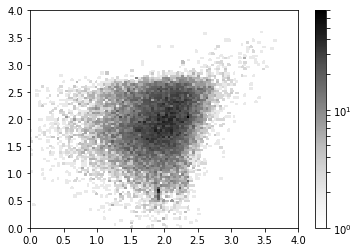

In [135]:
max = 4
xbins = np.linspace(0, max, 100)
ybins = xbins
H, xe, ye = np.histogram2d(np.log10(vl.value), np.log10(vb.value), bins=(xbins, ybins))


im = plt.pcolormesh(xe, ye, H.T,
              cmap='Greys', norm=mpl.colors.LogNorm()) #, vmin=-100, vmax=100)
plt.colorbar(im)


In [89]:
%%timeit -n1 -r1
foo = MC_error_propagation.MCvs(data['ra'],data['dec'],
                           data['pmra'], data['pmra_error'], 
                           data['pmdec'], data['pmdec_error'],
                           data['pmra_pmdec_corr'], 
                           data['int_average_g'], data['int_average_g_error'], 
                           data['ebv'], 1)

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/landerson/gaiaDR2/MC_error_propagation.py:84: RuntimeWarning: Degrees of freedom <= 0 for slice
  pm_b_pm_l_cov = np.array([np.cov(np.array([pm_l_i[i], pm_b_i[i]]))[0][1] for i in range(len(pm_b_i))])
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/landerson/gaiaDR2/MC_error_propagation.py:87: RuntimeWarning: Degrees

1min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
foo = MC_error_propagation.MCvs(data['ra'],data['dec'],
                           data['pmra'], data['pmra_error'], 
                           data['pmdec'], data['pmdec_error'],
                           data['pmra_pmdec_corr'], 
                           data['int_average_g'], data['int_average_g_error'], 
                           data['ebv'], 1)
foo

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/landerson/gaiaDR2/MC_error_propagation.py:84: RuntimeWarning: Degrees of freedom <= 0 for slice
  pm_b_pm_l_cov = np.array([np.cov(np.array([pm_l_i[i], pm_b_i[i]]))[0][1] for i in range(len(pm_b_i))])
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/landerson/gaiaDR2/MC_error_propagation.py:87: RuntimeWarning: Degrees

(-2.475807578180254,
 0.3614048967983881,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 87.90654896019278,
 -185.63350589831302,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]),
 array([-3., -3., -3., ..., -3., -3., -3.]))

In [92]:
len(data)

135825

In [98]:
foo[2].max()

0.0